# A. 신경망을 이용한 PRNG 분석

이 노트북의 목적은 주어진 PRNG의 암호학적 안전성을 따져보는 것입니다. 따라서 신경망으로 다음과 같은 두 종류의 모델을 만들어 접근합니다.

1. **Predictor**를 만드는 방법
    - 신경망을 이용하여 PRNG로 만들어진 (binary) sequence의 다음 값을 예측합니다. 정답률이 $0.5$에 가까울수록 좋은(안전한) PRNG입니다.
    
    
2. **Discriminator**를 만드는 방법
    - 신경망을 이용하여 각각 TRNG(True RNG)와 PRNG로 만들어진 (binary) sequence를 구분합니다. 마찬가지로 정답률이 $0.5$에 가까울수록 좋은(안전한) PRNG입니다.

이 노트북은 keras와 numpy를 사용합니다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras as keras
from keras import layers as layers
from keras import models as models

## 0. 학습 및 평가를 위한 보조함수 작성

우선 binary sequence로부터 학습 및 평가 데이터를 만들기 위한 보조함수를 작성합니다. 


### 0-1. Predictor를 학습/평가하기 위한 데이터를 생성하는 보조함수

이 함수의 이름은 **generate_data_pred**이며, 입출력은 다음과 같습니다.

- 입력
    - **raw_seq** : PRNG로 생성한 binary sequence
    - **seq_len** : 학습 데이터로 사용할 부분수열의 길이입니다. **x**에 해당합니다.
    - **cv_raito** : 학습 데이터 / 평가 데이터의 비율입니다.
    - **bCategorical** : 학습 및 평가 데이터를 '계열'자료로 만들지의 여부입니다. binary sequence이니 사실 필요없는 항목이지만, 비교를 위해...
    - **bTargetSequence** : 학습 모델이 RNN 중에서 many-to-many모델인 경우, target(**y**) 또한 sequence여야 합니다. 이 여부를 지정합니다.
    - **bShuffle** : 학습 데이터를 뒤섞습니다.
- 출력
    - **raw_seq**의 부분수열로부터 학습 및 평가 데이터의 쌍 (x, y)를 만듭니다.
        - **raw_seq**의 i번째 항목부터 (i + seq_len) 번째 항목을 취해, 길이 (seq_len + 1)인 부분수열을 만듭니다.
        - 첫 **seq_len** 비트를 **x**로 출력합니다.
        - bTargetSequence가 True인 경우 1번째부터 **seq_len + 1**번째 비트를 **y**로 출력합니다.
        - bTargetSequence가 False인 경우 **seq_len + 1**번째 비트를 **y**로 출력합니다.


In [25]:
def generate_data_pred(raw_seq, seq_len, cv_ratio = 0.9, bCategorical = True, bTargetSequence = False, bShuffle = True):
    max_data = np.max(raw_seq) + 1
    _data = [raw_seq[i : i + seq_len + 1] for i in range(0, len(raw_seq) - seq_len - 1)]
    if bCategorical:
        _data = keras.utils.to_categorical(_data, max_data)
        _data = np.array(_data).reshape(-1, seq_len + 1, max_data)
    else:
        _data = np.array(_data).reshape(-1, seq_len + 1, 1)
        
    if bShuffle:
        np.random.shuffle(_data)
        
    num_data = len(_data)
    num_training_data = int(num_data * cv_ratio)
    num_test_data = num_data - num_training_data
    
    x_train = _data[:num_training_data, :-1, :]
    if bTargetSequence:
        y_train = _data[:num_training_data, 1:, :]
    else:
        y_train = _data[:num_training_data, -1, :]
    
    x_test = _data[num_training_data:, :-1, :]
    if bTargetSequence:
        y_test = _data[num_training_data:, 1:, :]
    else:
        y_test = _data[num_training_data:, -1, :]
    
    return x_train, y_train, x_test, y_test

In [12]:
keras.utils.to_categorical([[[1, 2, 3], [3, 4, 5]], [[1, 2, 4], [1, 5, 3]]], 6)

array([[[[0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.]],

        [[0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 1.]]],


       [[[0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 0., 0.]]]], dtype=float32)

### 0-2. Discriminator를 학습/평가하기 위한 데이터를 생성하는 보조함수

이 함수의 이름은 **generate_data_disc**이며, 입출력은 다음과 같습니다.

- 입력
    - **raw_seq_true** : TRNG, 또는 그에 준하는 충분히 안전한 PRNG로 생성한 binary sequence
    - **raw_seq_false** : 우리가 분석할 PRNG로 생성한 binary sequence
    - **seq_len** : 학습 데이터로 사용할 부분수열의 길이입니다. **x**에 해당합니다.
    - **cv_raito** : 학습 데이터 / 평가 데이터의 비율입니다.
    - **bCategorical** : 학습 및 평가 데이터를 '계열'자료로 만들지의 여부입니다. binary sequence이니 사실 필요없는 항목이지만, 비교를 위해...
    - **bShuffle** : 학습 데이터를 뒤섞습니다.
- 출력
    - **raw_seq_true**와 **raw_seq_false**의 부분수열들로부터 학습 및 평가 데이터의 쌍 (x, y)를 만듭니다.
        - **raw_seq_true**의 i번째 항목부터 (i + seq_len - 1) 번째 항목을 취해, 길이 **seq_len**인 부분수열을 만듭니다.
        - 이 부분수열을 **x**로 출력하고, 이 때 **y**는 항상 1로 줍니다.
        - **raw_seq_false**에도 같은 작업을 합니다. 이 때 **y**는 항상 0으로 줍니다.

In [38]:
def generate_data_disc(raw_seq_true, raw_seq_false, seq_len, cv_ratio = 0.9, bCategorical = True, bShuffle = True):
    max_data = max(np.max(raw_seq_true), np.max(raw_seq_false)) + 1
    _data = [raw_seq_true [i : i + seq_len] + [1] for i in range(0, len(raw_seq_true)  - seq_len)]
    _data = _data + [raw_seq_false[i : i + seq_len] + [0] for i in range(0, len(raw_seq_false) - seq_len)]
    if bCategorical:
        _data = keras.utils.to_categorical(_data, max_data)
        _data = np.array(_data).reshape(-1, seq_len + 1, max_data)
    else:
        _data = np.array(_data).reshape(-1, seq_len + 1, 1)

    if bShuffle:
        np.random.shuffle(_data)
        
    num_data = len(_data)
    num_training_data = int(num_data * cv_ratio)
    num_test_data = num_data - num_training_data
    
    x_train = _data[:num_training_data, :-1, :]
    y_train = _data[:num_training_data, -1, 0:2]
    
    x_test = _data[num_training_data:, :-1, :]
    y_test = _data[num_training_data:, -1, 0:2]
    
    return x_train, y_train, x_test, y_test

### 0-3. DNN 및 RNN을 만들기 위한 보조함수

매번 Dense니 LSTM이니 덧붙이기 지겨우니까... 하나의 class로 만들어버리려고 합니다.

입력 및 출력 차원을 정해주고, 출력의 activation을 정해준 다음, RNN layer에 들어있는 LSTM unit의 개수, Dense layer에 들어있는 뉴런의 개수를 입력하면 그대로 NN을 생성해주는 함수입니다. 단, compile은 따로 해야합니다.

In [175]:
class build_NN(keras.models.Model):
    def __init__(self, input_dim = (10,), output_dim = 1, output_activation = 'sigmoid', LSTMs = [10], Denses = [10]):
        inputs = keras.layers.Input(input_dim, name = 'input')
        r = inputs
        if len(LSTMs) == 0 and len(input_dim) >= 2:
            r = keras.layers.Flatten(name = 'flatten')(r)
        for i, num_units in enumerate(LSTMs[:-1]):
            r = keras.layers.LSTM(num_units, return_sequences=True, name = 'LSTM_{}'.format(i + 1))(r)
        if len(LSTMs) > 0:
            r = keras.layers.LSTM(LSTMs[-1], return_sequences=False, name = 'LSTM_{}'.format(len(LSTMs)))(r)            
            
        for i, num_units in enumerate(Denses):
            if isinstance(num_units, list):
                r = keras.layers.Dense(num_units[0], activation = num_units[1], name = 'dense_{}'.format(i + 1))(r)
            else:
                r = keras.layers.Dense(num_units, activation = 'relu', name = 'dense_{}'.format(i + 1))(r)
        outputs = keras.layers.Dense(output_dim, activation = output_activation, name = 'output')(r)
        
        super().__init__(inputs, outputs)
        self.summary()
        return

## 1. LCG 분석

신경망을 이용하여 LCG의 다음 bit를 추정해 보려고 합니다.

### 1-1. LCG class 정의

Linear Congruential Generator(LCG)는 다음 식으로 정의됩니다.

$$x_{n+1} = a \cdot x_n + c \mod m $$

이를 이용하여 LCG를 위한 class를 아래처럼 정의합니다.

In [3]:
class LCG():
    def __init__(self, m, a, c):
        self.m = m
        self.a = a
        self.c = c
        
    def _generate(self, x0):
        return (self.a * x0 + self.c) % self.m
    
    def init(self, x0):
        self.x = x0
        return
    
    def generate(self, length):
        seq = []
        x1 = self.x
        for i in range(length):
            x1 = self._generate(x1)
            seq.append(x1)
        self.x = x1
        return seq
    
    def draw_plot(self, seq):
        fig = plt.figure(figsize = (12, 6))
        ax = plt.subplot(1, 2, 1)
        ax.plot(seq, '.', linewidth = 0.1, markersize = 2)
        ax.set_title('LCG with $m={}$, $a={}$, $c={}$'.format(self.m, self.a, self.c))
        ax.set_xlabel('$n$')
        ax.set_ylabel('$x_n$')

        ax = plt.subplot(1, 2, 2)
        seqs = np.array([(seq[i], seq[i + 1]) for i in range(0, len(seq) - 1)], dtype = [('x', int), ('y', int)])
        seqs = np.sort(seqs, order = 'x')
        ax.plot([v for (v, _) in seqs], [v for (_, v) in seqs], '.')
        ax.set_title('LCG with $m={}$, $a={}$, $c={}$'.format(self.m, self.a, self.c))
        ax.set_xlabel('$x_n$')
        ax.set_ylabel('$x_{n+1}$')

        plt.show()        

간단한 LCG를 하나 만들어보면 아래와 같습니다. 파라메터로는 $m=29$, $a = 11$, $c = -4$를 사용했습니다.

$(m,c) = 1$이고 $29 | m$인데 $29$는 $a-1=10$을 나누지 않으므로 이 LCG의 주기는 $29$가 아닙니다.

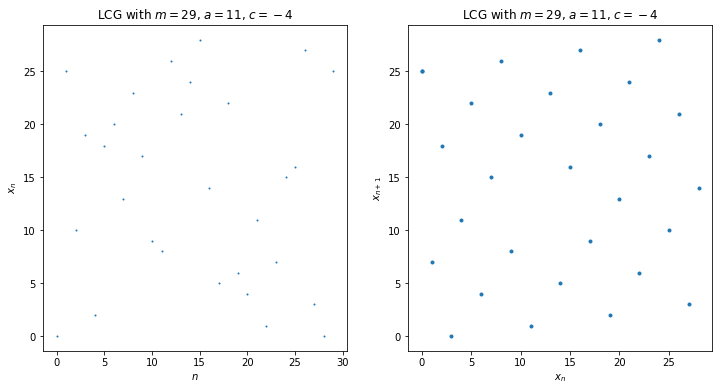

In [6]:
m = 29
a = 11
c = -4

lcg = LCG(m, a, c)
lcg.init(3)

# LCG를 이용하여 길이가 30인 binary sequence를 생성합니다.
seq = lcg.generate(30)
lcg.draw_plot(seq)

실제 주기는 $28$인 것을 확인할 수 있습니다.

한편 $m=28$, $a=11$, $c=-4$로 잡으면 $LCG(28, 11, -4)$의 모양은 더 단순해집니다. 주기는 6밖에 안 됩니다.

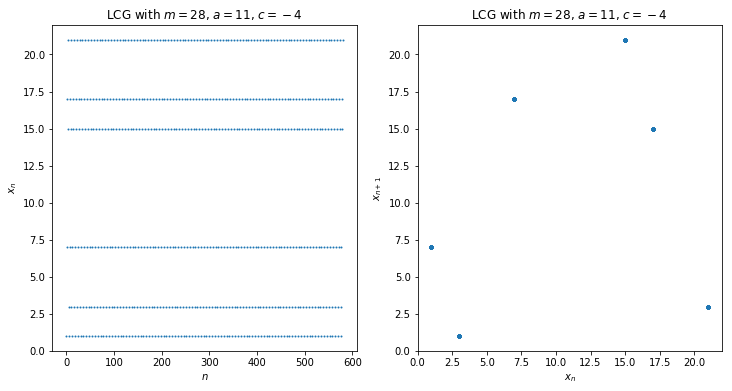

In [7]:
m = 28
a = 11
c = -4

lcg = LCG(m, a, c)
lcg.init(3)

# LCG를 이용하여 길이가 581인 binary sequence를 생성합니다.
seq = lcg.generate(581)
lcg.draw_plot(seq)

### 1-2. LCG에 대한 Predictor 학습 및 평가

이제 Predictor를 만들어 평가해봅시다. LCG의 경우 PRNG의 출력이 $0$ ~ $m-1$ 사이의 값이라는 것에 주의해야합니다.

우선 DNN을 이용한 모델입니다.

In [47]:
#분석할 LCG 정의 및 binary sequence 뽑아두기

m = 29
a = 11
c = 25

lcg = LCG(m, a, c)
lcg.init(3)
seq_lcg_29_11_25 = lcg.generate(581)

#TRNG(...?)를 이용하여 binary sequence 만들어두기
seq_lcg_29_true = list(np.random.randint(0, m, [581,]))

In [143]:
n_lcg = 2

LCG_DNN_pred1 = build_NN(input_dim=(n_lcg, m), output_dim = m, output_activation='softmax', LSTMs = [], Denses = [m])
LCG_DNN_pred1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2, 29)             0         
_________________________________________________________________
flatten (Flatten)            (None, 58)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                1711      
_________________________________________________________________
output (Dense)               (None, 29)                870       
Total params: 2,581
Trainable params: 2,581
Non-trainable params: 0
_________________________________________________________________


In [139]:
x_train_lcg, y_train_lcg, x_test_lcg, y_test_lcg = generate_data_pred(seq_lcg_29_11_25, n_lcg, bCategorical=True)
LCG_DNN_pred1.fit(x_train_lcg, y_train_lcg,
              validation_data=[x_test_lcg, y_test_lcg], initial_epoch=0, epochs=30)

Train on 520 samples, validate on 58 samples
Epoch 1/30
520/520 [==============================] - 1s 2ms/step - loss: 3.3484 - acc: 0.0442 - val_loss: 3.2871 - val_acc: 0.1034
Epoch 2/30
520/520 [==============================] - 0s 130us/step - loss: 3.2476 - acc: 0.1885 - val_loss: 3.1924 - val_acc: 0.3621
Epoch 3/30
520/520 [==============================] - 0s 131us/step - loss: 3.1480 - acc: 0.3788 - val_loss: 3.0943 - val_acc: 0.4310
Epoch 4/30
520/520 [==============================] - 0s 131us/step - loss: 3.0428 - acc: 0.5115 - val_loss: 2.9870 - val_acc: 0.5172
Epoch 5/30
520/520 [==============================] - 0s 129us/step - loss: 2.9280 - acc: 0.6231 - val_loss: 2.8671 - val_acc: 0.6552
Epoch 6/30
520/520 [==============================] - 0s 131us/step - loss: 2.8000 - acc: 0.7038 - val_loss: 2.7333 - val_acc: 0.7069
Epoch 7/30
520/520 [==============================] - 0s 129us/step - loss: 2.6574 - acc: 0.8077 - val_loss: 2.5799 - val_acc: 0.8621
Epoch 8/30
520/520 

LCG는 워낙에 단순한 형태다보니, DNN이 그 구조를 잘 분석해내는 것처럼 보입니다. 그럼 RNN은 어떨까요?

In [146]:
#RNN답게 부분 수열의 길이는 미리 지정하지 않았습니다.

#inp = layers.Input(shape = (None, m), name = 'input')
#lstm = layers.LSTM(m, name = 'LSTM_1')(inp)
#out = layers.Dense(m, activation = 'softmax', name = 'output')(lstm)

LCG_RNN_pred1 = build_NN(input_dim=(None, m), output_dim = m, output_activation='softmax', LSTMs = [m], Denses = [])
LCG_RNN_pred1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 29)          0         
_________________________________________________________________
LSTM_1 (LSTM)                (None, 29)                6844      
_________________________________________________________________
output (Dense)               (None, 29)                870       
Total params: 7,714
Trainable params: 7,714
Non-trainable params: 0
_________________________________________________________________


In [147]:
x_train_lcg, y_train_lcg, x_test_lcg, y_test_lcg = generate_data_pred(seq_lcg_29_11_25, n_lcg, bCategorical=True)
LCG_RNN_pred1.fit(x_train_lcg, y_train_lcg,
              validation_data=[x_test_lcg, y_test_lcg], initial_epoch=0, epochs=30)

Train on 520 samples, validate on 58 samples
Epoch 1/30
520/520 [==============================] - 2s 3ms/step - loss: 3.3649 - acc: 0.0038 - val_loss: 3.3475 - val_acc: 0.0690
Epoch 2/30
520/520 [==============================] - 0s 274us/step - loss: 3.3330 - acc: 0.1404 - val_loss: 3.3190 - val_acc: 0.2931
Epoch 3/30
520/520 [==============================] - 0s 277us/step - loss: 3.3000 - acc: 0.4615 - val_loss: 3.2878 - val_acc: 0.5517
Epoch 4/30
520/520 [==============================] - 0s 277us/step - loss: 3.2632 - acc: 0.7308 - val_loss: 3.2521 - val_acc: 0.6552
Epoch 5/30
520/520 [==============================] - 0s 281us/step - loss: 3.2196 - acc: 0.8288 - val_loss: 3.2081 - val_acc: 0.7586
Epoch 6/30
520/520 [==============================] - 0s 273us/step - loss: 3.1673 - acc: 0.9096 - val_loss: 3.1548 - val_acc: 0.8276
Epoch 7/30
520/520 [==============================] - 0s 275us/step - loss: 3.1023 - acc: 0.9404 - val_loss: 3.0874 - val_acc: 0.8276
Epoch 8/30
520/520 

### 1-3. LCG에 대한 Discriminator 학습 및 평가

이제 Discriminator 만들어 평가해봅시다. 마찬가지로 LCG의 경우 PRNG의 출력이 $0$ ~ $m-1$ 사이의 값이라는 것에 주의해야합니다.

우선 DNN을 이용한 모델입니다.

In [148]:
m = 29
n_lcg = 2
#inp = layers.Input(shape = (n_lcg, m), name = 'input')
#flat = layers.Flatten()(inp)
#d1 = layers.Dense(m, activation = 'relu', name = 'dense_1')(flat)
#out = layers.Dense(2, activation = 'softmax', name = 'output')(d1)

LCG_DNN_disc1 = build_NN(input_dim=(n_lcg, m), output_dim = 2, output_activation='softmax', LSTMs = [], Denses = [m])
LCG_DNN_disc1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2, 29)             0         
_________________________________________________________________
flatten (Flatten)            (None, 58)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                1711      
_________________________________________________________________
output (Dense)               (None, 2)                 60        
Total params: 1,771
Trainable params: 1,771
Non-trainable params: 0
_________________________________________________________________


In [149]:
x_train_lcg, y_train_lcg, x_test_lcg, y_test_lcg = generate_data_disc(seq_lcg_29_true,
                                                                      seq_lcg_29_11_25,
                                                                      n_lcg, bCategorical=True)
LCG_DNN_disc1.fit(x_train_lcg, y_train_lcg,
              validation_data=[x_test_lcg, y_test_lcg], initial_epoch=0, epochs=30)

Train on 1042 samples, validate on 116 samples
Epoch 1/30
1042/1042 [==============================] - 1s 1ms/step - loss: 0.6821 - acc: 0.5038 - val_loss: 0.6827 - val_acc: 0.5172
Epoch 2/30
1042/1042 [==============================] - 0s 126us/step - loss: 0.6614 - acc: 0.6353 - val_loss: 0.6658 - val_acc: 0.6379
Epoch 3/30
1042/1042 [==============================] - 0s 128us/step - loss: 0.6419 - acc: 0.7303 - val_loss: 0.6474 - val_acc: 0.7328
Epoch 4/30
1042/1042 [==============================] - 0s 127us/step - loss: 0.6202 - acc: 0.7898 - val_loss: 0.6273 - val_acc: 0.7759
Epoch 5/30
1042/1042 [==============================] - 0s 127us/step - loss: 0.5965 - acc: 0.8253 - val_loss: 0.6026 - val_acc: 0.8017
Epoch 6/30
1042/1042 [==============================] - 0s 125us/step - loss: 0.5698 - acc: 0.8493 - val_loss: 0.5785 - val_acc: 0.8103
Epoch 7/30
1042/1042 [==============================] - 0s 119us/step - loss: 0.5408 - acc: 0.8685 - val_loss: 0.5509 - val_acc: 0.8534
Epo

길이 2인 걸 던져주고 TRNG와 LCG를 구분하는 건 사실 명확하지 않습니다. (학습 데이터 중에 우연히 같은 tuple이 존재할 수 있으니까...) 그러니 3으로 늘려봅시다.

In [151]:
m = 29
n_lcg = 3
#inp = layers.Input(shape = (n_lcg, m), name = 'input')
#flat = layers.Flatten()(inp)
#d1 = layers.Dense(m, activation = 'relu', name = 'dense_1')(flat)
#out = layers.Dense(2, activation = 'softmax', name = 'output')(d1)

LCG_DNN_disc2 = build_NN(input_dim=(n_lcg, m), output_dim = 2, output_activation='softmax', LSTMs = [], Denses = [m])
LCG_DNN_disc2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 3, 29)             0         
_________________________________________________________________
flatten (Flatten)            (None, 87)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                2552      
_________________________________________________________________
output (Dense)               (None, 2)                 60        
Total params: 2,612
Trainable params: 2,612
Non-trainable params: 0
_________________________________________________________________


In [152]:
x_train_lcg, y_train_lcg, x_test_lcg, y_test_lcg = generate_data_disc(seq_lcg_29_true,
                                                                      seq_lcg_29_11_25,
                                                                      n_lcg, bCategorical=True)
LCG_DNN_disc2.fit(x_train_lcg, y_train_lcg,
              validation_data=[x_test_lcg, y_test_lcg], initial_epoch=0, epochs=30)

Train on 1040 samples, validate on 116 samples
Epoch 1/30
1040/1040 [==============================] - 1s 1ms/step - loss: 0.6876 - acc: 0.5558 - val_loss: 0.6888 - val_acc: 0.5603
Epoch 2/30
1040/1040 [==============================] - 0s 148us/step - loss: 0.6458 - acc: 0.6673 - val_loss: 0.6581 - val_acc: 0.5948
Epoch 3/30
1040/1040 [==============================] - 0s 148us/step - loss: 0.6061 - acc: 0.7433 - val_loss: 0.6285 - val_acc: 0.6810
Epoch 4/30
1040/1040 [==============================] - 0s 149us/step - loss: 0.5633 - acc: 0.8250 - val_loss: 0.5946 - val_acc: 0.7672
Epoch 5/30
1040/1040 [==============================] - 0s 148us/step - loss: 0.5187 - acc: 0.8750 - val_loss: 0.5562 - val_acc: 0.7931
Epoch 6/30
1040/1040 [==============================] - 0s 138us/step - loss: 0.4728 - acc: 0.9154 - val_loss: 0.5199 - val_acc: 0.8190
Epoch 7/30
1040/1040 [==============================] - 0s 122us/step - loss: 0.4278 - acc: 0.9288 - val_loss: 0.4820 - val_acc: 0.8362
Epo

RNN은 굳이 하지 않겠습니다. ^^

### 1-3. Categorical이 아니면...

LCG의 출력은 $0$ ~ $m-1$ 이라서 categorical로 바꿔서 데이터를 만들었는데, 그냥 정수(또는 0~1 사이로 normalize한 값)를 사용하면 어떻게 될까요?

신경망이 유리해지도록 부분수열의 길이를 4로 늘렸습니다. 아울러 accuracy는 수동으로 계산해 줄 필요가 있습니다. (왜?)

In [155]:
from keras import backend as K

n_lcg = 4
#inp = layers.Input(shape = (n_lcg,), name = 'input')
#d = layers.Dense(m, activation = 'relu', name = 'dense_1')(inp)
#d = layers.Dense(m, activation = 'relu', name = 'dense_2')(d)
#out = layers.Dense(1, activation = 'sigmoid', name = 'output')(d)

def acc_LCG_DNN_pred2(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true * m), K.round(y_pred * m)))

LCG_DNN_pred2 = build_NN(input_dim=(n_lcg,), output_dim = 1, output_activation='sigmoid', LSTMs = [], Denses = [m, m])
LCG_DNN_pred2.compile(optimizer = 'adam', loss = 'mse', metrics = [acc_LCG_DNN_pred2])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                145       
_________________________________________________________________
dense_2 (Dense)              (None, 29)                870       
_________________________________________________________________
output (Dense)               (None, 1)                 30        
Total params: 1,045
Trainable params: 1,045
Non-trainable params: 0
_________________________________________________________________


In [156]:
x_train_lcg_nocat, y_train_lcg_nocat, x_test_lcg_nocat, y_test_lcg_nocat = generate_data_pred(seq_lcg_29_11_25, n_lcg, bCategorical=False)
LCG_DNN_pred2.fit(x_train_lcg_nocat[:, :, 0] / m, y_train_lcg_nocat / m,
              validation_data=[x_test_lcg_nocat[:, :, 0] / m, y_test_lcg_nocat / m], initial_epoch=0, epochs=200)

Train on 518 samples, validate on 58 samples
Epoch 1/200
518/518 [==============================] - 1s 2ms/step - loss: 0.0868 - acc_LCG_DNN_pred2: 0.0097 - val_loss: 0.0916 - val_acc_LCG_DNN_pred2: 0.0000e+00
Epoch 2/200
518/518 [==============================] - 0s 133us/step - loss: 0.0818 - acc_LCG_DNN_pred2: 0.0386 - val_loss: 0.0881 - val_acc_LCG_DNN_pred2: 0.0172
Epoch 3/200
518/518 [==============================] - 0s 131us/step - loss: 0.0781 - acc_LCG_DNN_pred2: 0.0367 - val_loss: 0.0847 - val_acc_LCG_DNN_pred2: 0.0172
Epoch 4/200
518/518 [==============================] - 0s 129us/step - loss: 0.0748 - acc_LCG_DNN_pred2: 0.0367 - val_loss: 0.0826 - val_acc_LCG_DNN_pred2: 0.0172
Epoch 5/200
518/518 [==============================] - 0s 129us/step - loss: 0.0720 - acc_LCG_DNN_pred2: 0.0367 - val_loss: 0.0797 - val_acc_LCG_DNN_pred2: 0.0172
Epoch 6/200
518/518 [==============================] - 0s 126us/step - loss: 0.0691 - acc_LCG_DNN_pred2: 0.0463 - val_loss: 0.0769 - val_a

Epoch 51/200
518/518 [==============================] - 0s 129us/step - loss: 0.0051 - acc_LCG_DNN_pred2: 0.3224 - val_loss: 0.0046 - val_acc_LCG_DNN_pred2: 0.2931
Epoch 52/200
518/518 [==============================] - 0s 131us/step - loss: 0.0049 - acc_LCG_DNN_pred2: 0.2741 - val_loss: 0.0044 - val_acc_LCG_DNN_pred2: 0.2586
Epoch 53/200
518/518 [==============================] - 0s 126us/step - loss: 0.0046 - acc_LCG_DNN_pred2: 0.2703 - val_loss: 0.0042 - val_acc_LCG_DNN_pred2: 0.3448
Epoch 54/200
518/518 [==============================] - 0s 122us/step - loss: 0.0044 - acc_LCG_DNN_pred2: 0.2876 - val_loss: 0.0040 - val_acc_LCG_DNN_pred2: 0.3966
Epoch 55/200
518/518 [==============================] - 0s 122us/step - loss: 0.0042 - acc_LCG_DNN_pred2: 0.2915 - val_loss: 0.0037 - val_acc_LCG_DNN_pred2: 0.3448
Epoch 56/200
518/518 [==============================] - 0s 133us/step - loss: 0.0039 - acc_LCG_DNN_pred2: 0.2529 - val_loss: 0.0037 - val_acc_LCG_DNN_pred2: 0.2586
Epoch 57/200
518

Epoch 100/200
518/518 [==============================] - 0s 131us/step - loss: 3.5180e-04 - acc_LCG_DNN_pred2: 0.6950 - val_loss: 3.9271e-04 - val_acc_LCG_DNN_pred2: 0.6724
Epoch 101/200
518/518 [==============================] - 0s 137us/step - loss: 3.4277e-04 - acc_LCG_DNN_pred2: 0.6988 - val_loss: 3.8561e-04 - val_acc_LCG_DNN_pred2: 0.6724
Epoch 102/200
518/518 [==============================] - 0s 124us/step - loss: 3.2994e-04 - acc_LCG_DNN_pred2: 0.6969 - val_loss: 3.6446e-04 - val_acc_LCG_DNN_pred2: 0.6724
Epoch 103/200
518/518 [==============================] - 0s 122us/step - loss: 3.0759e-04 - acc_LCG_DNN_pred2: 0.7220 - val_loss: 3.6427e-04 - val_acc_LCG_DNN_pred2: 0.6207
Epoch 104/200
518/518 [==============================] - 0s 120us/step - loss: 3.0233e-04 - acc_LCG_DNN_pred2: 0.7066 - val_loss: 3.3801e-04 - val_acc_LCG_DNN_pred2: 0.6724
Epoch 105/200
518/518 [==============================] - 0s 133us/step - loss: 2.8623e-04 - acc_LCG_DNN_pred2: 0.7259 - val_loss: 3.241

518/518 [==============================] - 0s 129us/step - loss: 8.8471e-05 - acc_LCG_DNN_pred2: 0.8919 - val_loss: 1.1391e-04 - val_acc_LCG_DNN_pred2: 0.9138
Epoch 148/200
518/518 [==============================] - 0s 127us/step - loss: 8.6018e-05 - acc_LCG_DNN_pred2: 0.8919 - val_loss: 1.2177e-04 - val_acc_LCG_DNN_pred2: 0.9138
Epoch 149/200
518/518 [==============================] - 0s 135us/step - loss: 8.5614e-05 - acc_LCG_DNN_pred2: 0.8996 - val_loss: 1.1066e-04 - val_acc_LCG_DNN_pred2: 0.9310
Epoch 150/200
518/518 [==============================] - 0s 129us/step - loss: 8.3316e-05 - acc_LCG_DNN_pred2: 0.9151 - val_loss: 1.0853e-04 - val_acc_LCG_DNN_pred2: 0.9310
Epoch 151/200
518/518 [==============================] - 0s 135us/step - loss: 8.3454e-05 - acc_LCG_DNN_pred2: 0.9151 - val_loss: 1.0799e-04 - val_acc_LCG_DNN_pred2: 0.9310
Epoch 152/200
518/518 [==============================] - 0s 137us/step - loss: 8.3186e-05 - acc_LCG_DNN_pred2: 0.9228 - val_loss: 1.1612e-04 - val_ac

518/518 [==============================] - 0s 124us/step - loss: 4.2987e-05 - acc_LCG_DNN_pred2: 0.9672 - val_loss: 6.2951e-05 - val_acc_LCG_DNN_pred2: 0.9483
Epoch 195/200
518/518 [==============================] - 0s 126us/step - loss: 4.2565e-05 - acc_LCG_DNN_pred2: 0.9672 - val_loss: 5.9893e-05 - val_acc_LCG_DNN_pred2: 0.9483
Epoch 196/200
518/518 [==============================] - 0s 124us/step - loss: 4.1794e-05 - acc_LCG_DNN_pred2: 0.9672 - val_loss: 5.9545e-05 - val_acc_LCG_DNN_pred2: 0.9483
Epoch 197/200
518/518 [==============================] - 0s 135us/step - loss: 4.0985e-05 - acc_LCG_DNN_pred2: 0.9672 - val_loss: 6.3562e-05 - val_acc_LCG_DNN_pred2: 0.9483
Epoch 198/200
518/518 [==============================] - 0s 131us/step - loss: 4.0920e-05 - acc_LCG_DNN_pred2: 0.9672 - val_loss: 5.8357e-05 - val_acc_LCG_DNN_pred2: 0.9483
Epoch 199/200
518/518 [==============================] - 0s 129us/step - loss: 4.0457e-05 - acc_LCG_DNN_pred2: 0.9672 - val_loss: 5.7735e-05 - val_ac

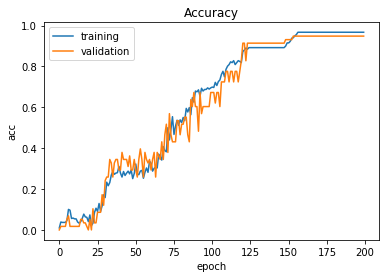

In [157]:
plt.plot(LCG_DNN_pred2.history.history['acc_LCG_DNN_pred2'])
plt.plot(LCG_DNN_pred2.history.history['val_acc_LCG_DNN_pred2'])
plt.title('Accuracy')
plt.legend(['training', 'validation'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

In [158]:
n_lcg = 4

#inp = layers.Input(shape = (None, 1), name = 'input')
#lstm = layers.LSTM(n_lcg, return_sequences = False, name = 'lstm_1')(inp)
#dense = layers.Dense(m, activation = 'relu', name = 'dense_1')(lstm)
#out = layers.Dense(1, activation = 'sigmoid', name = 'output')(dense)

LCG_RNN_pred2 = build_NN(input_dim=(None, 1), output_dim = 1, output_activation='sigmoid', LSTMs = [n_lcg], Denses = [m])
LCG_RNN_pred2.compile(optimizer = 'adam', loss = 'mse', metrics = [acc_LCG_DNN_pred2])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 1)           0         
_________________________________________________________________
LSTM_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 29)                145       
_________________________________________________________________
output (Dense)               (None, 1)                 30        
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________


In [159]:
LCG_RNN_pred2.fit(x_train_lcg_nocat[:, :, :] / m, y_train_lcg_nocat / m,
              validation_data=[x_test_lcg_nocat[:, :, :] / m, y_test_lcg_nocat / m], initial_epoch=0, epochs=200)

Train on 518 samples, validate on 58 samples
Epoch 1/200
518/518 [==============================] - 2s 4ms/step - loss: 0.0847 - acc_LCG_DNN_pred2: 0.0347 - val_loss: 0.0962 - val_acc_LCG_DNN_pred2: 0.0517
Epoch 2/200
518/518 [==============================] - 0s 384us/step - loss: 0.0846 - acc_LCG_DNN_pred2: 0.0347 - val_loss: 0.0962 - val_acc_LCG_DNN_pred2: 0.0517
Epoch 3/200
518/518 [==============================] - 0s 384us/step - loss: 0.0846 - acc_LCG_DNN_pred2: 0.0347 - val_loss: 0.0962 - val_acc_LCG_DNN_pred2: 0.0517
Epoch 4/200
518/518 [==============================] - 0s 382us/step - loss: 0.0846 - acc_LCG_DNN_pred2: 0.0347 - val_loss: 0.0963 - val_acc_LCG_DNN_pred2: 0.0517
Epoch 5/200
518/518 [==============================] - 0s 388us/step - loss: 0.0846 - acc_LCG_DNN_pred2: 0.0347 - val_loss: 0.0962 - val_acc_LCG_DNN_pred2: 0.0517
Epoch 6/200
518/518 [==============================] - 0s 398us/step - loss: 0.0846 - acc_LCG_DNN_pred2: 0.0347 - val_loss: 0.0962 - val_acc_L

518/518 [==============================] - 0s 380us/step - loss: 0.0604 - acc_LCG_DNN_pred2: 0.0405 - val_loss: 0.0675 - val_acc_LCG_DNN_pred2: 0.0000e+00
Epoch 51/200
518/518 [==============================] - 0s 377us/step - loss: 0.0586 - acc_LCG_DNN_pred2: 0.0000e+00 - val_loss: 0.0651 - val_acc_LCG_DNN_pred2: 0.0000e+00
Epoch 52/200
518/518 [==============================] - 0s 379us/step - loss: 0.0574 - acc_LCG_DNN_pred2: 0.0000e+00 - val_loss: 0.0653 - val_acc_LCG_DNN_pred2: 0.0000e+00
Epoch 53/200
518/518 [==============================] - 0s 375us/step - loss: 0.0559 - acc_LCG_DNN_pred2: 0.0000e+00 - val_loss: 0.0629 - val_acc_LCG_DNN_pred2: 0.0000e+00
Epoch 54/200
518/518 [==============================] - 0s 373us/step - loss: 0.0546 - acc_LCG_DNN_pred2: 0.0232 - val_loss: 0.0614 - val_acc_LCG_DNN_pred2: 0.0345
Epoch 55/200
518/518 [==============================] - 0s 379us/step - loss: 0.0538 - acc_LCG_DNN_pred2: 0.0347 - val_loss: 0.0610 - val_acc_LCG_DNN_pred2: 0.0345
E

Epoch 100/200
518/518 [==============================] - 0s 375us/step - loss: 0.0426 - acc_LCG_DNN_pred2: 0.1776 - val_loss: 0.0492 - val_acc_LCG_DNN_pred2: 0.1207
Epoch 101/200
518/518 [==============================] - 0s 377us/step - loss: 0.0427 - acc_LCG_DNN_pred2: 0.1699 - val_loss: 0.0493 - val_acc_LCG_DNN_pred2: 0.1207
Epoch 102/200
518/518 [==============================] - 0s 377us/step - loss: 0.0426 - acc_LCG_DNN_pred2: 0.1293 - val_loss: 0.0487 - val_acc_LCG_DNN_pred2: 0.0690
Epoch 103/200
518/518 [==============================] - 0s 375us/step - loss: 0.0425 - acc_LCG_DNN_pred2: 0.1544 - val_loss: 0.0489 - val_acc_LCG_DNN_pred2: 0.1207
Epoch 104/200
518/518 [==============================] - 0s 379us/step - loss: 0.0423 - acc_LCG_DNN_pred2: 0.1544 - val_loss: 0.0485 - val_acc_LCG_DNN_pred2: 0.0690
Epoch 105/200
518/518 [==============================] - 0s 373us/step - loss: 0.0424 - acc_LCG_DNN_pred2: 0.1795 - val_loss: 0.0489 - val_acc_LCG_DNN_pred2: 0.1207
Epoch 106/

518/518 [==============================] - 0s 375us/step - loss: 0.0395 - acc_LCG_DNN_pred2: 0.0676 - val_loss: 0.0461 - val_acc_LCG_DNN_pred2: 0.0690
Epoch 150/200
518/518 [==============================] - 0s 377us/step - loss: 0.0394 - acc_LCG_DNN_pred2: 0.0734 - val_loss: 0.0459 - val_acc_LCG_DNN_pred2: 0.0517
Epoch 151/200
518/518 [==============================] - 0s 373us/step - loss: 0.0395 - acc_LCG_DNN_pred2: 0.0927 - val_loss: 0.0467 - val_acc_LCG_DNN_pred2: 0.0690
Epoch 152/200
518/518 [==============================] - 0s 375us/step - loss: 0.0395 - acc_LCG_DNN_pred2: 0.0888 - val_loss: 0.0457 - val_acc_LCG_DNN_pred2: 0.0517
Epoch 153/200
518/518 [==============================] - 0s 375us/step - loss: 0.0392 - acc_LCG_DNN_pred2: 0.0502 - val_loss: 0.0457 - val_acc_LCG_DNN_pred2: 0.0517
Epoch 154/200
518/518 [==============================] - 0s 377us/step - loss: 0.0392 - acc_LCG_DNN_pred2: 0.0734 - val_loss: 0.0461 - val_acc_LCG_DNN_pred2: 0.0690
Epoch 155/200
518/518 [=

Epoch 199/200
518/518 [==============================] - 0s 373us/step - loss: 0.0343 - acc_LCG_DNN_pred2: 0.1081 - val_loss: 0.0390 - val_acc_LCG_DNN_pred2: 0.1034
Epoch 200/200
518/518 [==============================] - 0s 375us/step - loss: 0.0343 - acc_LCG_DNN_pred2: 0.0792 - val_loss: 0.0379 - val_acc_LCG_DNN_pred2: 0.0517


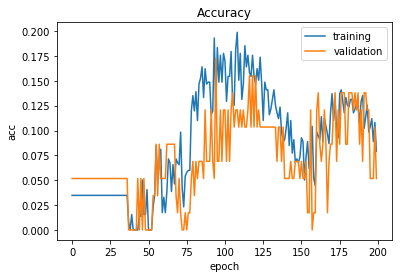

In [160]:
plt.plot(LCG_RNN_pred2.history.history['acc_LCG_DNN_pred2'])
plt.plot(LCG_RNN_pred2.history.history['val_acc_LCG_DNN_pred2'])
plt.title('Accuracy')
plt.legend(['training', 'validation'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

예상외로 RNN 쪽이 성적이 좋지 않습니다. sequence를 다루니 유리할 거라고 생각했는데...?

## 2. LFSR 분석

이번에는 신경망을 이용하여 LFSR을 다뤄보려고 합니다.

### 2-1. LFSR class 정의

LFSR은 아래 페이지처럼 정의되었습니다.
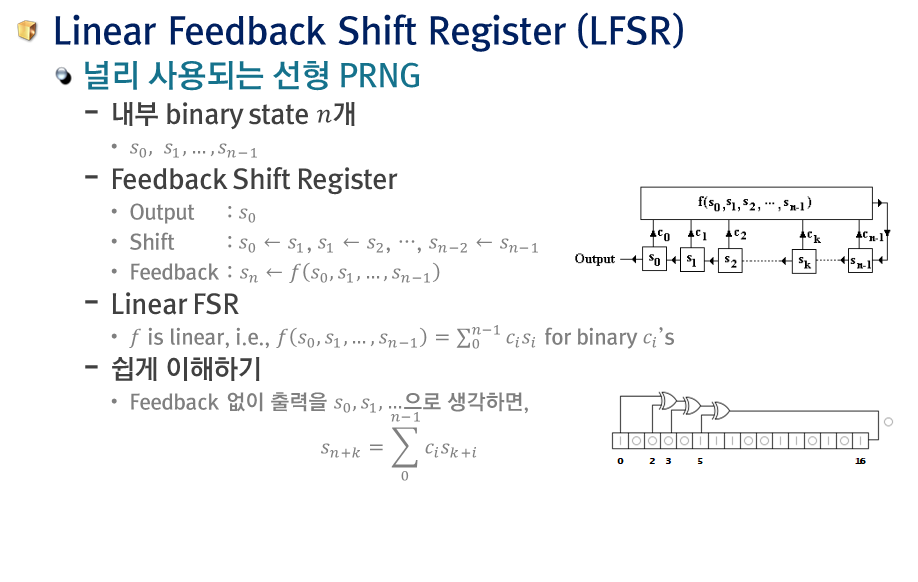

여기서 characteristic polynomial이 중요했는데, 결국 LFSR의 출력은 내부 상태(길이 $n$인 vector)와 char. polynomial의 계수로 만들어진 길이 $n$ vector의 내적입니다.

다양한 $n$에 대해 널리 쓰이는 char. poly.는 아래 표를 참고하시기 바랍니다. (주 : 표에는 feedback poly.라고 되어 있지만 char. poly.와 비슷한 개념입니다.)
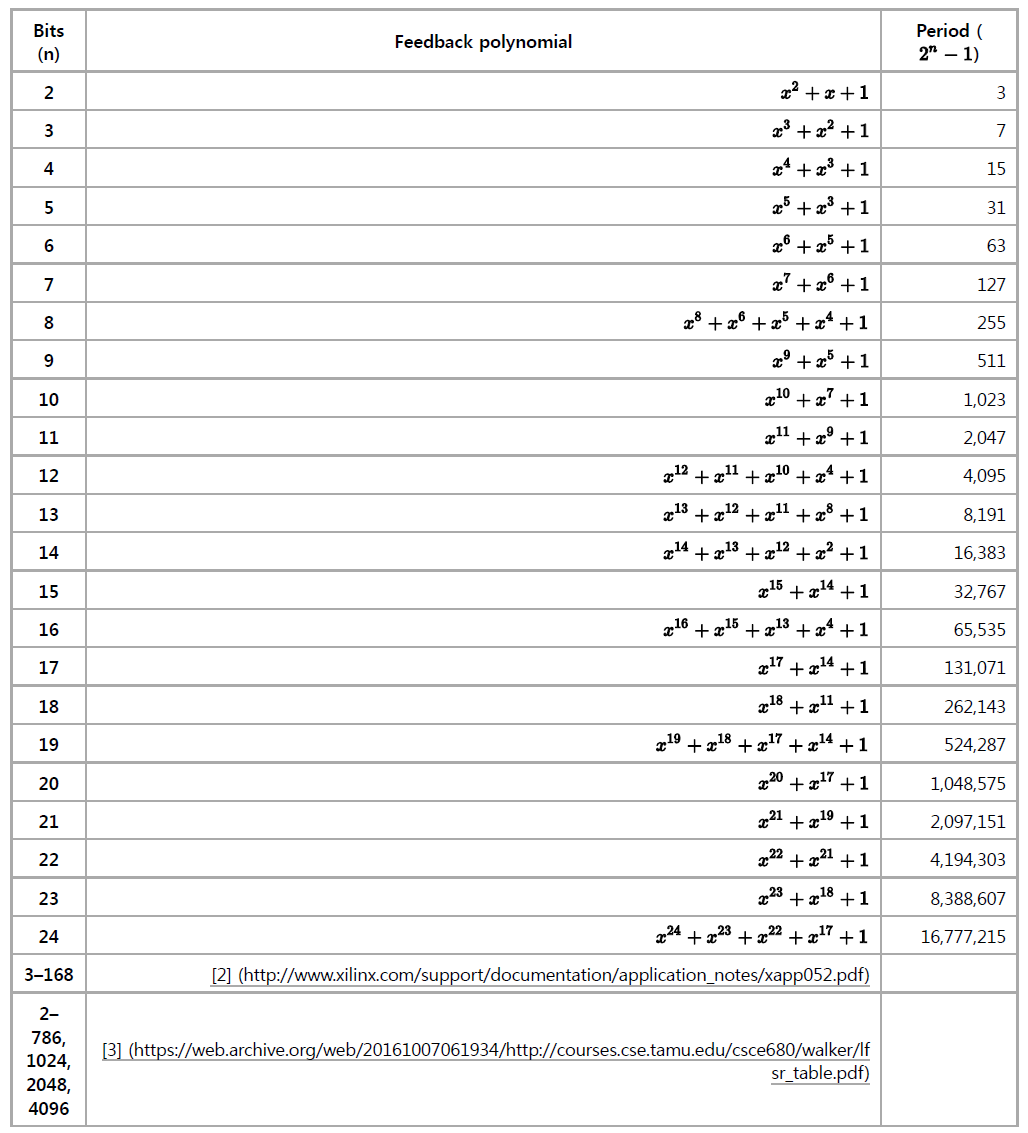

In [107]:
class LFSR():
    def __init__(self, n, char_poly):
        if len(char_poly) != (n + 1):
            assert False, "char_poly의 차수는 n보다 1 커야 합니다."
        self.n = n
        self.char_poly = np.array(char_poly)
        self.state = np.zeros((n,))
        return
    
    def _generate(self, state):
        output = state[0]
        feedback = np.dot(state, self.char_poly[:-1]) % 2
        state[:-1] = state[1:]
        state[-1] = feedback
        return output
    
    def init(self, init_state):
        self.state = init_state
        return
    
    def generate(self, length, return_state = False):
        seq = []
        state_seq = np.zeros((length, self.n))
        state = self.state
        for i in range(length):
            output = self._generate(state)
            state_seq[i, :] = state
            seq.append(output)
        self.state = state
        if return_state:
            return seq, state_seq
        return seq

    def get_char_poly(self):
        poly = "1"
        char_poly = self.char_poly
        for i in range(1, len(char_poly)):
            if char_poly[i] == 1:
                if i == 1:
                    poly = poly + " + x"
                else:
                    poly = poly + " + x^{" + "{}".format(i) + "}"
        return poly
    
    def draw_plot(self, state_seq):
        state_seq_np = np.array(state_seq).reshape(-1, self.n)
        bin_exp = np.ones((self.n,))
        for i in range(1, self.n):
            bin_exp[i] = bin_exp[i - 1] * 2
        seq = np.matmul(state_seq_np, bin_exp)
        fig = plt.figure(figsize = (12, 6))
        ax = plt.subplot(1, 2, 1)
        ax.plot(seq, '.', markersize = max(64 / len(state_seq), 0.2))
        ax.set_title('LFSR with char. poly = ${}$'.format(self.get_char_poly()))
        ax.set_xlabel('$i$')
        ax.set_ylabel('$state_i$')

        ax = plt.subplot(1, 2, 2)
        ax.plot(seq[:-1], seq[1:], '.')
        ax.set_title('LFSR with char. poly = ${}$'.format(self.get_char_poly()))
        ax.set_xlabel('$state_i$')
        ax.set_ylabel('$state_{i+1}$')

        plt.show()
        return

예를 들어 $n=4$인 경우 표에서 char. poly를 $1 + x^3 + x^4$로 가져올 수 있습니다. 그러면 LFSR은 아래처럼 생성할 수 있습니다. initial state는 $[1, 0, 0, 1]$로 가정합니다. 여기서 그래프의 $state_i$는 원래 길이 $n$인 vector인데 2진수로 취급해서 정수로 변환한 값입니다.

$state_i$와 $state_{i+1}$ 사이의 관계를 보면 선형인듯 선형아닌 관계가 나타납니다.

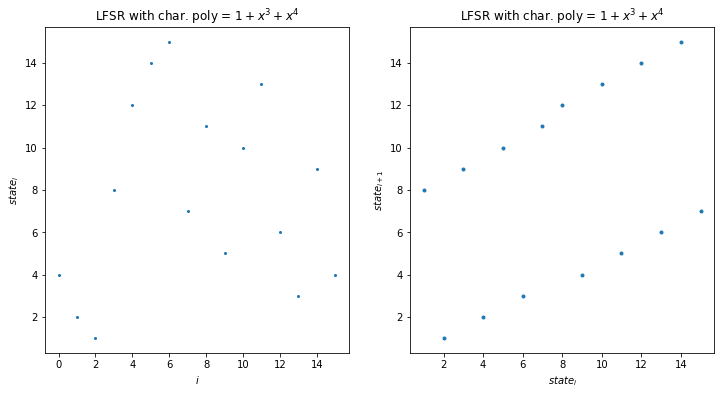

In [111]:
lfsr4 = LFSR(4, [1, 0, 0, 1, 1])
lfsr4.init([1, 0, 0, 1])
seq_LFSR_4, states_LFSR_4 = lfsr4.generate(2 ** 4, return_state = True)
lfsr4.draw_plot(states_LFSR_4)

$n=16$인 경우에는 $1+x^4 + x^{13} + x^{15} + x^{16}$을 사용하면 됩니다. initial state를 무작위로 설정한 경우 LFSR은 다음과 같습니다.

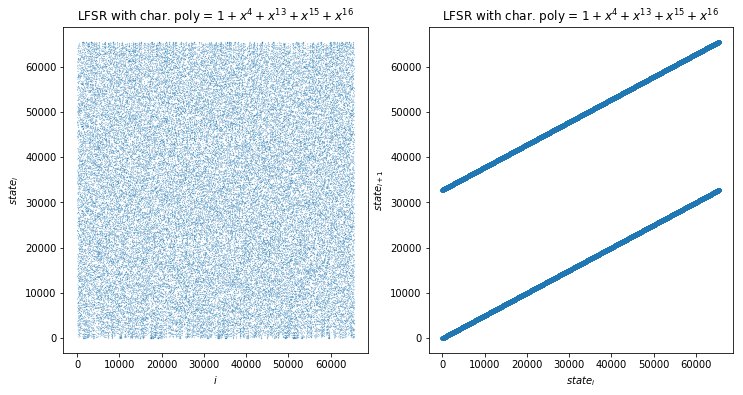

In [112]:
#LFSR를 이용하여 binary sequence를 만들어둡니다.

n = 16

init_state = np.random.rand(n) > 0.5
lfsr16 = LFSR(n, char_poly = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1])
lfsr16.init(init_state)
seq_LFSR_16, states_LFSR_16 = lfsr16.generate(2 ** n, return_state = True)
lfsr16.draw_plot(states_LFSR_16)

### 2-2. LFSR에 대한 Predictor 학습 및 평가

이제 Predictor를 만들어 평가해봅시다. 우선 DNN을 이용한 모델입니다.

In [114]:
#LFSR를 이용하여 binary sequence를 만들어둡니다.
n = 16

init_state = np.random.rand(n) > 0.5
lfsr16 = LFSR(n, char_poly = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1])
lfsr16.init(init_state)
seq_LFSR_16, states_LFSR_16 = lfsr16.generate(2 ** n, return_state = True)

#TRNG를 이용하여 비슷한 길이의 binary sequence를 만들어둡니다.
seq_LFSR_16_true = list(np.random.randint(0, 2, [2 ** n,]))

Dense layer를 각각 $2n$, $n$, $\lceil \frac{n}{2} \rceil$개 쌓아봅니다.

In [161]:
n_lfsr = n * 2

#inp = layers.Input(shape = (n_lfsr,), name = 'input')
#d1 = layers.Dense(n_lfsr, activation = 'relu', name = 'dense_1')(inp)
#d2 = layers.Dense(n, activation = 'relu', name = 'dense_2')(d1)
#d3 = layers.Dense(n // 2, activation = 'relu', name = 'dense_3')(d2)
#out = layers.Dense(1, activation = 'sigmoid', name = 'output')(d3)

DNN_LFSR_pred1 = build_NN(input_dim=(n_lfsr,), output_dim = 1, output_activation='sigmoid',
                          LSTMs = [], Denses = [n_lfsr, n, n // 2])
DNN_LFSR_pred1.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 1,729
Trainable params: 1,729
Non-trainable params: 0
_________________________________________________________________


In [162]:
x_train_LFSR, y_train_LFSR, x_test_LFSR, y_test_LFSR = generate_data_pred(seq_LFSR_16, n_lfsr, bCategorical=False)

DNN_LFSR_pred1.fit(x_train_LFSR[:, :, 0], y_train_LFSR,
                   validation_data=[x_test_LFSR[:, :, 0], y_test_LFSR], initial_epoch=0, epochs=30)

Train on 58952 samples, validate on 6551 samples
Epoch 1/30
58952/58952 [==============================] - 9s 152us/step - loss: 0.2489 - acc: 0.5117 - val_loss: 0.2169 - val_acc: 0.7290
Epoch 2/30
58952/58952 [==============================] - 8s 128us/step - loss: 0.0170 - acc: 0.9902 - val_loss: 4.7049e-04 - val_acc: 1.0000
Epoch 3/30
58952/58952 [==============================] - 8s 128us/step - loss: 1.8560e-04 - acc: 1.0000 - val_loss: 6.2130e-05 - val_acc: 1.0000
Epoch 4/30
58952/58952 [==============================] - 8s 128us/step - loss: 3.1345e-05 - acc: 1.0000 - val_loss: 2.1904e-05 - val_acc: 1.0000
Epoch 5/30
58952/58952 [==============================] - 8s 130us/step - loss: 1.0038e-05 - acc: 1.0000 - val_loss: 5.3784e-06 - val_acc: 1.0000
Epoch 6/30
58952/58952 [==============================] - 8s 128us/step - loss: 3.1059e-06 - acc: 1.0000 - val_loss: 1.8090e-06 - val_acc: 1.0000
Epoch 7/30
58952/58952 [==============================] - 8s 129us/step - loss: 1.0286e

너무(...) 잘 되니까 이번에는 Dense를 $n$, $n$개 쌓아봅니다.

In [163]:
n_lfsr = n

DNN_LFSR_pred2 = build_NN(input_dim=(n_lfsr,), output_dim = 1, output_activation='sigmoid',
                          LSTMs = [], Denses = [n_lfsr, n])
DNN_LFSR_pred2.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________


In [164]:
x_train_LFSR, y_train_LFSR, x_test_LFSR, y_test_LFSR = generate_data_pred(seq_LFSR_16, n_lfsr, bCategorical=False)

DNN_LFSR_pred2.fit(x_train_LFSR[:, :, 0], y_train_LFSR,
                   validation_data=[x_test_LFSR[:, :, 0], y_test_LFSR], initial_epoch=0, epochs=10)

Train on 58967 samples, validate on 6552 samples
Epoch 1/10
58967/58967 [==============================] - 8s 137us/step - loss: 0.2470 - acc: 0.5393 - val_loss: 0.1999 - val_acc: 0.7993
Epoch 2/10
58967/58967 [==============================] - 7s 111us/step - loss: 0.0408 - acc: 0.9657 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3/10
58967/58967 [==============================] - 7s 111us/step - loss: 5.4672e-04 - acc: 1.0000 - val_loss: 1.9670e-04 - val_acc: 1.0000
Epoch 4/10
58967/58967 [==============================] - 7s 111us/step - loss: 1.0372e-04 - acc: 1.0000 - val_loss: 5.0993e-05 - val_acc: 1.0000
Epoch 5/10
58967/58967 [==============================] - 7s 111us/step - loss: 2.8936e-05 - acc: 1.0000 - val_loss: 1.5742e-05 - val_acc: 1.0000
Epoch 6/10
58967/58967 [==============================] - 7s 111us/step - loss: 9.2158e-06 - acc: 1.0000 - val_loss: 5.2594e-06 - val_acc: 1.0000
Epoch 7/10
58967/58967 [==============================] - 7s 111us/step - loss: 3.1196e-06 

생각보다 DNN을 이용한 LFSR의 다음 비트 예측은 매우 쉬운 것처럼 보입니다. 심지어 $n$개만 쌓아도 됩니다.

In [165]:
DNN_LFSR_pred3 = build_NN(input_dim=(n_lfsr,), output_dim = 1, output_activation='sigmoid',
                          LSTMs = [], Denses = [n])
DNN_LFSR_pred3.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [166]:
DNN_LFSR_pred3.fit(x_train_LFSR[:, :, 0], y_train_LFSR,
                   validation_data=[x_test_LFSR[:, :, 0], y_test_LFSR], initial_epoch=0, epochs=10)

Train on 58967 samples, validate on 6552 samples
Epoch 1/10
58967/58967 [==============================] - 7s 121us/step - loss: 0.2355 - acc: 0.6448 - val_loss: 0.2035 - val_acc: 0.7715
Epoch 2/10
58967/58967 [==============================] - 6s 95us/step - loss: 0.1692 - acc: 0.8395 - val_loss: 0.1173 - val_acc: 0.9017
Epoch 3/10
58967/58967 [==============================] - 6s 95us/step - loss: 0.0916 - acc: 0.9058 - val_loss: 0.0661 - val_acc: 0.9368
Epoch 4/10
58967/58967 [==============================] - 6s 95us/step - loss: 0.0434 - acc: 0.9932 - val_loss: 0.0266 - val_acc: 1.0000
Epoch 5/10
58967/58967 [==============================] - 6s 94us/step - loss: 0.0170 - acc: 1.0000 - val_loss: 0.0093 - val_acc: 1.0000
Epoch 6/10
58967/58967 [==============================] - 6s 94us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 7/10
58967/58967 [==============================] - 6s 94us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 6.8323e-04 - val

여태까지는 LFSR의 한 주기에 들어가는 거의 모든 부분수열을 이용해서 학습시켰습니다. 만일 일부 부분수열만 주면 어떻게 될까요?

사실 LFSR의 모든 부분수열은 내부적으로 같은 규칙을 이용해서 만들어진 것이므로, 그 개수는 학습이 진행될 수 있을 정도만 주어지면 충분합니다. 대신에 epoch을 늘리면 학습이 잘 됩니다.

In [174]:
DNN_LFSR_pred4 = build_NN(input_dim=(n_lfsr,), output_dim = 1, output_activation='sigmoid',
                          LSTMs = [], Denses = [n])
DNN_LFSR_pred4.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

x_train_LFSR, y_train_LFSR, x_test_LFSR, y_test_LFSR = generate_data_pred(seq_LFSR_16[:(100 * n)], n_lfsr, bCategorical=False)
DNN_LFSR_pred4.fit(x_train_LFSR[:, :, 0], y_train_LFSR,
                   validation_data=[x_test_LFSR[:, :, 0], y_test_LFSR], initial_epoch=0, epochs=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
Train on 1424 samples, validate on 159 samples
Epoch 1/200
1424/1424 [==============================] - 2s 1ms/step - loss: 0.2626 - acc: 0.5000 - val_loss: 0.2600 - val_acc: 0.4780
Epoch 2/200
1424/1424 [==============================] - 0s 114us/step - loss: 0.2595 - acc: 0.5007 - val_loss: 0.2585 - val_acc: 0.4591
Epoch 3/200
1424/1424 [==============================] - 0s 112us/step - loss: 0.2572 - a

Epoch 55/200
1424/1424 [==============================] - 0s 100us/step - loss: 0.2246 - acc: 0.6369 - val_loss: 0.2322 - val_acc: 0.5283
Epoch 56/200
1424/1424 [==============================] - 0s 99us/step - loss: 0.2237 - acc: 0.6412 - val_loss: 0.2325 - val_acc: 0.5409
Epoch 57/200
1424/1424 [==============================] - 0s 100us/step - loss: 0.2232 - acc: 0.6412 - val_loss: 0.2332 - val_acc: 0.5472
Epoch 58/200
1424/1424 [==============================] - 0s 99us/step - loss: 0.2227 - acc: 0.6440 - val_loss: 0.2320 - val_acc: 0.5472
Epoch 59/200
1424/1424 [==============================] - 0s 100us/step - loss: 0.2221 - acc: 0.6517 - val_loss: 0.2314 - val_acc: 0.5346
Epoch 60/200
1424/1424 [==============================] - 0s 100us/step - loss: 0.2214 - acc: 0.6412 - val_loss: 0.2313 - val_acc: 0.5535
Epoch 61/200
1424/1424 [==============================] - 0s 100us/step - loss: 0.2207 - acc: 0.6489 - val_loss: 0.2313 - val_acc: 0.5535
Epoch 62/200
1424/1424 [============

1424/1424 [==============================] - 0s 105us/step - loss: 0.1082 - acc: 0.8757 - val_loss: 0.1041 - val_acc: 0.8805
Epoch 115/200
1424/1424 [==============================] - 0s 104us/step - loss: 0.1069 - acc: 0.8947 - val_loss: 0.1037 - val_acc: 0.8616
Epoch 116/200
1424/1424 [==============================] - 0s 100us/step - loss: 0.1056 - acc: 0.8876 - val_loss: 0.1006 - val_acc: 0.8994
Epoch 117/200
1424/1424 [==============================] - 0s 105us/step - loss: 0.1045 - acc: 0.9017 - val_loss: 0.1000 - val_acc: 0.8742
Epoch 118/200
1424/1424 [==============================] - 0s 103us/step - loss: 0.1034 - acc: 0.8968 - val_loss: 0.0990 - val_acc: 0.8742
Epoch 119/200
1424/1424 [==============================] - 0s 100us/step - loss: 0.1024 - acc: 0.8855 - val_loss: 0.0967 - val_acc: 0.8931
Epoch 120/200
1424/1424 [==============================] - 0s 107us/step - loss: 0.1014 - acc: 0.9031 - val_loss: 0.0966 - val_acc: 0.8742
Epoch 121/200
1424/1424 [================

1424/1424 [==============================] - 0s 100us/step - loss: 0.0281 - acc: 1.0000 - val_loss: 0.0288 - val_acc: 1.0000
Epoch 174/200
1424/1424 [==============================] - 0s 100us/step - loss: 0.0273 - acc: 1.0000 - val_loss: 0.0277 - val_acc: 1.0000
Epoch 175/200
1424/1424 [==============================] - 0s 99us/step - loss: 0.0263 - acc: 1.0000 - val_loss: 0.0268 - val_acc: 1.0000
Epoch 176/200
1424/1424 [==============================] - 0s 99us/step - loss: 0.0254 - acc: 1.0000 - val_loss: 0.0259 - val_acc: 1.0000
Epoch 177/200
1424/1424 [==============================] - 0s 100us/step - loss: 0.0246 - acc: 1.0000 - val_loss: 0.0250 - val_acc: 1.0000
Epoch 178/200
1424/1424 [==============================] - 0s 100us/step - loss: 0.0239 - acc: 1.0000 - val_loss: 0.0242 - val_acc: 1.0000
Epoch 179/200
1424/1424 [==============================] - 0s 100us/step - loss: 0.0230 - acc: 1.0000 - val_loss: 0.0234 - val_acc: 1.0000
Epoch 180/200
1424/1424 [==================

#### 이제 RNN을 이용한 predictor를 만들어 볼 차례입니다.

In [178]:
RNN_LFSR_pred1 = build_NN(input_dim=(None, 2), output_dim = 2, output_activation='softmax',
                          LSTMs = [n], Denses = [n, n // 2])
RNN_LFSR_pred1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 2)           0         
_________________________________________________________________
LSTM_1 (LSTM)                (None, 16)                1216      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
output (Dense)               (None, 2)                 18        
Total params: 1,642
Trainable params: 1,642
Non-trainable params: 0
_________________________________________________________________


In [179]:
x_train_LFSR_cat, y_train_LFSR_cat, x_test_LFSR_cat, y_test_LFSR_cat = generate_data_pred(seq_LFSR_16, 4 * n, bCategorical=True)

RNN_LFSR_pred1.fit(x_train_LFSR_cat, y_train_LFSR_cat, batch_size = 100,
              validation_data=[x_test_LFSR_cat, y_test_LFSR_cat], initial_epoch=0, epochs=30)

Train on 58923 samples, validate on 6548 samples
Epoch 1/30
58923/58923 [==============================] - 69s 1ms/step - loss: 0.6932 - acc: 0.5028 - val_loss: 0.6931 - val_acc: 0.5104
Epoch 2/30
58923/58923 [==============================] - 66s 1ms/step - loss: 0.6932 - acc: 0.4989 - val_loss: 0.6931 - val_acc: 0.5104
Epoch 3/30
55400/58923 [===========================>..] - ETA: 3s - loss: 0.6932 - acc: 0.5009

KeyboardInterrupt: 

시간관계상 생략하지만, RNN로는 predictor를 만들어도 거의 효과가 없습니다... 즉 RNN predictor가 보기에 LFSR은 암호학적으로 매우 안전한 PRNG입니다. :)

### 2-3. LFSR에 대한 Discriminator 학습 및 평가

앞에서 했던 것과 비슷하게 진행하면 됩니다. 우선 길이 $2n$인 부분수열을 이용해서 분류하는 모델입니다. Dense 계층은 $n$, $n$개를 쌓습니다.

In [185]:
DNN_LFSR_disc1 = build_NN(input_dim=(2 * n,), output_dim = 1, output_activation='sigmoid',
                          LSTMs = [], Denses = [n, n])
DNN_LFSR_disc1.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 817
Trainable params: 817
Non-trainable params: 0
_________________________________________________________________


In [186]:
x_train_LFSR, y_train_LFSR, x_test_LFSR, y_test_LFSR = generate_data_disc(seq_LFSR_16_true, seq_LFSR_16, 2 * n, bCategorical=False)

DNN_LFSR_disc1.fit(x_train_LFSR[:, :, 0], y_train_LFSR,
                   validation_data=[x_test_LFSR[:, :, 0], y_test_LFSR], initial_epoch=0, epochs=30)

Train on 117907 samples, validate on 13101 samples
Epoch 1/30
117907/117907 [==============================] - 16s 134us/step - loss: 0.2505 - acc: 0.4984 - val_loss: 0.2500 - val_acc: 0.5032
Epoch 2/30
117907/117907 [==============================] - 14s 118us/step - loss: 0.2491 - acc: 0.5075 - val_loss: 0.2428 - val_acc: 0.5511
Epoch 3/30
117907/117907 [==============================] - 14s 117us/step - loss: 0.2313 - acc: 0.5884 - val_loss: 0.2196 - val_acc: 0.6261
Epoch 4/30
117907/117907 [==============================] - 14s 117us/step - loss: 0.2019 - acc: 0.6739 - val_loss: 0.1874 - val_acc: 0.7082
Epoch 5/30
117907/117907 [==============================] - 14s 117us/step - loss: 0.1759 - acc: 0.7423 - val_loss: 0.1657 - val_acc: 0.7906
Epoch 6/30
117907/117907 [==============================] - 14s 117us/step - loss: 0.1577 - acc: 0.7962 - val_loss: 0.1504 - val_acc: 0.8036
Epoch 7/30
117907/117907 [==============================] - 14s 118us/step - loss: 0.1460 - acc: 0.8127

부분수열의 길이를 $n+1$로 하면?

In [189]:
DNN_LFSR_disc2 = build_NN(input_dim=(n + 1,), output_dim = 1, output_activation='sigmoid',
                          LSTMs = [], Denses = [n, n])
DNN_LFSR_disc2.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

x_train_LFSR, y_train_LFSR, x_test_LFSR, y_test_LFSR = generate_data_disc(seq_LFSR_16_true, seq_LFSR_16, n + 1, bCategorical=False)

DNN_LFSR_disc2.fit(x_train_LFSR[:, :, 0], y_train_LFSR,
                   validation_data=[x_test_LFSR[:, :, 0], y_test_LFSR], initial_epoch=0, epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                288       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________
Train on 117934 samples, validate on 13104 samples
Epoch 1/30
117934/117934 [==============================] - 16s 135us/step - loss: 0.2504 - acc: 0.5016 - val_loss: 0.2500 - val_acc: 0.5014
Epoch 2/30
117934/117934 [==============================] - 14s 118us/step - loss: 0

KeyboardInterrupt: 

하지만 부분수열의 길이가 $n$이면 제대로 동작하지 않습니다. 이것은 LFSR의 구조 및 동작방식을 생각하면 당연한 일입니다.

In [190]:
DNN_LFSR_disc3 = build_NN(input_dim=(n,), output_dim = 1, output_activation='sigmoid',
                          LSTMs = [], Denses = [n, n])
DNN_LFSR_disc3.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

x_train_LFSR, y_train_LFSR, x_test_LFSR, y_test_LFSR = generate_data_disc(seq_LFSR_16_true, seq_LFSR_16, n, bCategorical=False)

DNN_LFSR_disc3.fit(x_train_LFSR[:, :, 0], y_train_LFSR,
                   validation_data=[x_test_LFSR[:, :, 0], y_test_LFSR], initial_epoch=0, epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________
Train on 117936 samples, validate on 13104 samples
Epoch 1/30
117936/117936 [==============================] - 16s 137us/step - loss: 0.2504 - acc: 0.5000 - val_loss: 0.2501 - val_acc: 0.5025
Epoch 2/30
117936/117936 [==============================] - 14s 118us/step - loss: 0

KeyboardInterrupt: 

#### RNN을 이용한 discriminator라면?

In [193]:
RNN_LFSR_disc1 = build_NN(input_dim=(2 * n, 1), output_dim = 1, output_activation='sigmoid',
                          LSTMs = [n], Denses = [n, n])
RNN_LFSR_disc1.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

x_train_LFSR, y_train_LFSR, x_test_LFSR, y_test_LFSR = generate_data_disc(seq_LFSR_16_true, seq_LFSR_16, 2 * n, bCategorical=False)

RNN_LFSR_disc1.fit(x_train_LFSR, y_train_LFSR,
                   validation_data=[x_test_LFSR, y_test_LFSR], initial_epoch=0, epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 1)             0         
_________________________________________________________________
LSTM_1 (LSTM)                (None, 16)                1152      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 1,713
Trainable params: 1,713
Non-trainable params: 0
_________________________________________________________________
Train on 117907 samples, validate on 13101 samples
Epoch 1/30
117907/117907 [==============================] - 262s 2ms/step - loss: 0.2501 

KeyboardInterrupt: 

## 3. Blum-Blum-Shub (B. B. S)


## 3-1. BBS class 정의

BBS PRNG는 다음처럼 정의됩니다. 서로 다른 큰 소수 $p$, $q$에 대해 $M=pq$라 할 때, $x_i$는 다음 점화식으로 정의됩니다.

$$x_{n+1} = x_n^2 \mod M$$
이 때 $x_0$은 0, 1이 아니며 $M$과 서로 소여야 합니다.

그리고 BBS PRNG의 출력 bit는 $x_i$가 가진 1비트짜리 정보입니다. 예를 들어 LSB($x_i$), MSB($x_i$), odd_parity($x_i$) 등이 될 수 있습니다.

여기서는 가장 간단하게 LSB($x_i$)를 사용한 BBS를 만들겠습니다. isprime 함수는 적당한 $p$, $q$를 얻기 위해 사용할 수 있는 보조함수입니다.

In [194]:
class BBS():
    def __init__(self, p, q):
        if not isprime(p) or not isprime(q):
            assert False, "p와 q는 소수여야 합니다."
        if p % 4 != 3 or q % 4 != 3:
            assert False, "p와 q는 mod 4로 3이어야 합니다."
        self.M = p * q
        self.x = 0
        return
    
    def _generate(self, x):
        return (x ** 2) % self.M
    
    def init(self, x0):
        self.x = x0
        return
    
    def generate(self, length):
        seq = []
        x = self.x
        for i in range(length):
            x = self._generate(x)
            seq.append(x % 2)
        self.x = x
        return seq
    
def isprime(n):
    bdd = n ** 0.5
    for i in range(2, int(bdd) + 1):
        if n % i == 0:
            return False;
    return True

In [195]:
p = 64067
q = 64091
bbs = BBS(p = p, q = q)

In [196]:
bbs.init(999)
seq_bbs = bbs.generate(80000)
print(seq_bbs[:61])

[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]


## 3-2. BBS를 위한 Predictor 학습 및 평가

BBS는 워낙에 구조가 독특해서 신경망의 크기를 얼마로 잡아야할지 가늠하기가 좀 어렵습니다. 따라서 적당히 크게 만들어보겠습니다. 

참고로 $M = 64067 \cdot 64091$의 비트 길이는 32입니다.

In [197]:
n_bbs = 32
BBS_DNN_pred1 = build_NN(input_dim=(n_bbs + 1,), output_dim = 1, output_activation='sigmoid',
                          LSTMs = [], Denses = [n_bbs, n_bbs])
BBS_DNN_pred1.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

x_train_bbs, y_train_bbs, x_test_bbs, y_test_bbs = generate_data_pred(seq_bbs, n_bbs + 1, bCategorical=False)
BBS_DNN_pred1.fit(x_train_bbs[:, :, 0], y_train_bbs,
              validation_data=[x_test_bbs[:, :, 0], y_test_bbs], initial_epoch=0, epochs=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 33)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1088      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 2,177
Trainable params: 2,177
Non-trainable params: 0
_________________________________________________________________
Train on 71969 samples, validate on 7997 samples
Epoch 1/20
71969/71969 [==============================] - 11s 152us/step - loss: 0.2508 - acc: 0.4956 - val_loss: 0.2504 - val_acc: 0.4962
Epoch 2/20
71969/71969 [==============================] - 9s 121us/step - loss: 0.25

일견 acc가 0.5를 넘는 것 때문에 predictor가 성공했다고 생각할 수도 있지만, val_acc는 여전히 0.5에 머무릅니다. 따라서 이건 그저 과적합된 상태에 불과합니다.

모델을 좀 키워도 과적합만 더 생깁니다. 그렇다고 줄여서 해결될 리는 없고...

In [198]:
n_bbs = 64
BBS_DNN_pred2 = build_NN(input_dim=(n_bbs + 1,), output_dim = 1, output_activation='sigmoid',
                          LSTMs = [], Denses = [n_bbs, n_bbs])
BBS_DNN_pred2.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

x_train_bbs, y_train_bbs, x_test_bbs, y_test_bbs = generate_data_pred(seq_bbs, n_bbs + 1, bCategorical=False)
BBS_DNN_pred2.fit(x_train_bbs[:, :, 0], y_train_bbs,
              validation_data=[x_test_bbs[:, :, 0], y_test_bbs], initial_epoch=0, epochs=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 65)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4224      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 8,449
Trainable params: 8,449
Non-trainable params: 0
_________________________________________________________________
Train on 71940 samples, validate on 7994 samples
Epoch 1/20
71940/71940 [==============================] - 11s 154us/step - loss: 0.2506 - acc: 0.4992 - val_loss: 0.2502 - val_acc: 0.4985
Epoch 2/20
71940/71940 [==============================] - 9s 122us/step - loss: 0.25

RNN을 쓰면 좀 나으려나.

In [202]:
n_bbs = 64
BBS_RNN_pred1 = build_NN(input_dim=(n_bbs + 1, 1), output_dim = 1, output_activation='sigmoid',
                          LSTMs = [n_bbs, n_bbs], Denses = [n_bbs])
BBS_RNN_pred1.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

x_train_bbs, y_train_bbs, x_test_bbs, y_test_bbs = generate_data_pred(seq_bbs, n_bbs + 1, bCategorical=False)
BBS_RNN_pred1.fit(x_train_bbs[:, :, :], y_train_bbs,
              validation_data=[x_test_bbs[:, :, :], y_test_bbs], initial_epoch=0, epochs=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 65, 1)             0         
_________________________________________________________________
LSTM_1 (LSTM)                (None, 65, 64)            16896     
_________________________________________________________________
LSTM_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 54,145
Trainable params: 54,145
Non-trainable params: 0
_________________________________________________________________
Train on 71940 samples, validate on 7994 samples
Epoch 1/20
71940/71940 [==============================] - 636s 9ms/step - loss: 0.2501 - 

좀 작은 파라메터($p$, $q$)에 대해서는 DNN predictor가 어느 정도 작동합니다.

그 이유는 같이 생각해봐야 할 것 같습니다.

In [201]:
p = 1579
q = 1583
small_bbs = BBS(p = p, q = q)
small_bbs.init(999)
seq_small_bbs = small_bbs.generate(80000)

n_bbs = 22
BBS_DNN_pred3 = build_NN(input_dim=(n_bbs + 1,), output_dim = 1, output_activation='sigmoid',
                          LSTMs = [], Denses = [n_bbs, n_bbs])
BBS_DNN_pred3.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

x_train_bbs, y_train_bbs, x_test_bbs, y_test_bbs = generate_data_pred(seq_small_bbs, n_bbs + 1, bCategorical=False)
BBS_DNN_pred3.fit(x_train_bbs[:, :, 0], y_train_bbs,
              validation_data=[x_test_bbs[:, :, 0], y_test_bbs], initial_epoch=0, epochs=20)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 23)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 22)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 22)                506       
_________________________________________________________________
output (Dense)               (None, 1)                 23        
Total params: 1,057
Trainable params: 1,057
Non-trainable params: 0
_________________________________________________________________
Train on 71978 samples, validate on 7998 samples
Epoch 1/20
71978/71978 [==============================] - 11s 156us/step - loss: 0.2424 - acc: 0.5722 - val_loss: 0.2326 - val_acc: 0.6172
Epoch 2/20
71978/71978 [==============================] - 9s 124us/step - loss: 0.22